# Aprendizaje No Supervisado

En este notebook veremos los distintos tipos de aprendizaje no supervisado más comunes:

*   Preprocesamiento y aprendizaje de representaciones
*   Agrupamiento de datos

Y algunos de los métodos más populares para lleva a cabo esta tarea.

Al igual que en los notebooks anteriores, debemos ejecutar un pequeño preámbulo.



In [ ]:

#
# importación
#
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import numpy.random as rng

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 150

mpl.rcParams['font.size'] = 10
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'

from sklearn import datasets

cancer = datasets.load_breast_cancer()



## Preprocesamiento

Desde la adquisición hasta su uso para hacer inferencia, los datos usualmente deben ser acondicionados de alguna forma. A esto le llamamos _preprocesamiento_.
No es necesariamente un tipo de aprendizaje, si bien en general implica aprender o estimar alguna que otra estadística, o incluso realizar algún tipo de inferencia a partir de los datos.
Por ejemplo, es común que haya datos faltantes o incompletos.
También es común que haya datos anómalos, medidas erróneas debidas a equipos defectuosos, alguien que anotó mal en una planilla, etc..

En otros casos sucede que los propios métodos de ajuste de modelo son sensibles a ciertos aspectos, en principio irrelevantes, de los datos, a veces por cuestiones meramente técnicas. El ejemplo más común de esto es el _centrado_ y la _normalización_.

### Centrado

Se trata de restarle a todas las muestras de un conjunto de datos su valor medio. Si tenemos datos de entrenamiento $(\mathbf{x}_1,\mathbf{x}_2,\ldots,\mathbf{x}_n)$, se calcula

$$ \bar{\mathbf{x}} =  \frac{1}{n}\sum_{j=1}^{n}\mathbf{x}_j$$

y luego se transforma a todos los datos de entrenamiento mediante $\mathbf{x}_j \leftarrow \mathbf{x}_j - \bar{\mathbf{x}}$.

Notar que aquí cada dato $\mathbf{x}_j$ es un vector de $m$ dimensiones, donde cada dimensión $i$ corresponde a una característica. Para referirnos al elemento $i$-ésimo del dato $j$-ésimo escribimos $x_{ij}$.


### Normalización

Hay muchas variantes de este proceso, pero todas tienen el mismo objetivo: hacer que el rango de variación de las distintas variables en las muestras sea más o menos el mismo, y en torno a un mismo rango, típicamente $[0,1]$ o bien $[-1,1]$. La forma más común de hacer esto es calcular la desviación empírica en cada dimensión $i$ de los datos:

$$\sigma_i = \sqrt{(\sum_{j=1} x_{ij}-\bar{x}_j)^2}$$

y luego dividir los datos en la dimensión $i$ de manera que su desviación a lo largo del conjunto de entrenamiento pase a ser $1$: $x_{ij} \leftarrow x_{ij} / \sigma_i$.  A este tipo de normalización se le llama _estandarización_.

Otra muy común consiste en _estirar_ o _encoger_ los datos en cada dimensión de manera que el mínimo sea $0$ (puede ser $-1$) y el máximo sea $1$.

Veamos cómo realizar estas operaciones a mano. El paquete `sklearn` ya incluye todas estas operaciones, y se recomienda usar sus funciones siempre que sea posible, para no introducir errores innecesarios.

Por esta vez, por motivos didácticos, veremos cómo hacerlas a mano:





valor medio  [0.37083502 0.40310206]
desviacion de cada dimension  [0.13231878 0.43779271]


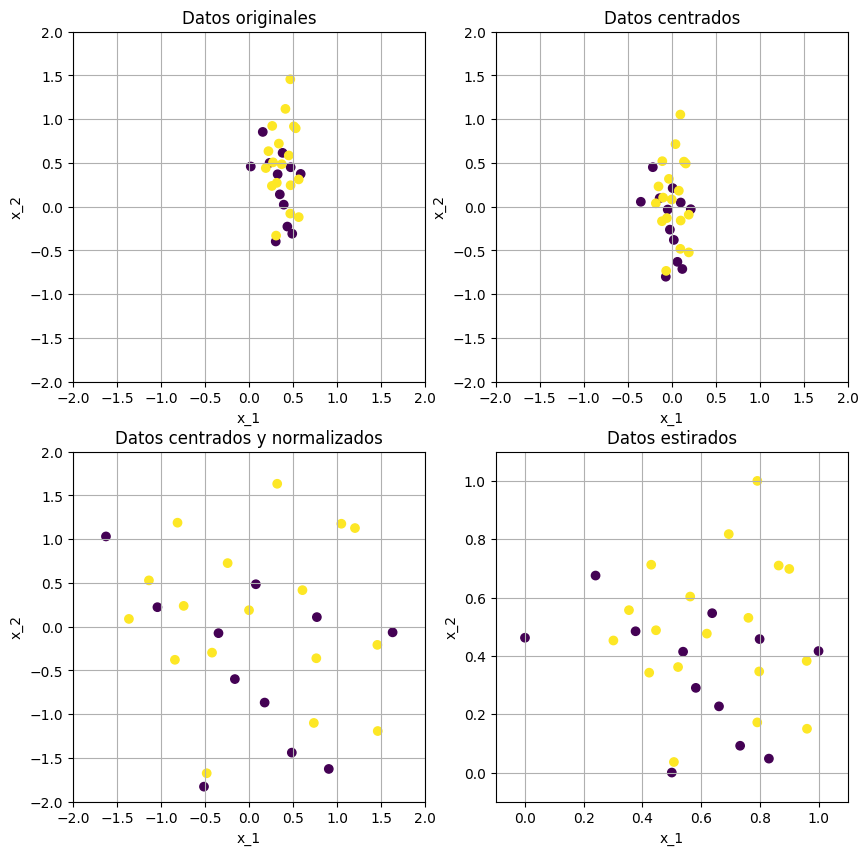

In [ ]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
#
# generamos un dataset al azar
#
m = 2
n = 30
random.seed(1234)
#
# matriz de datos: cada fila es un dato
# cada dato es un vector de dimensión m=2
#
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
X = [0.3,0.5] + np.dot(random.randn(n,m),np.diag([0.2,0.4]))
y = random.rand(n) > 0.5
plt.scatter(X[:,0],X[:,1],c=y)
plt.grid(True)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.title('Datos originales')

#
# centramos:
#
plt.subplot(2,2,2)
xbar = np.mean(X,axis=0) # tomamos el valor medio de cada columna
print('valor medio ',xbar)
X = X - xbar

plt.scatter(X[:,0],X[:,1],c=y)
plt.grid(True)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.title('Datos centrados')
#
# estandarización
#
sigma = np.std(X,axis=0) # tomamos la desviación emírica de cada columna
print('desviacion de cada dimension ',sigma)
X = X / sigma

plt.subplot(2,2,3)
plt.scatter(X[:,0],X[:,1],c=y)
plt.grid(True)
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('Datos centrados y normalizados')

#
# estiramiento de rango
#
xmin = np.min(X,axis=0)
xmax = np.max(X,axis=0)
X = (X-xmin)/(xmax-xmin)

plt.subplot(2,2,4)
plt.scatter(X[:,0],X[:,1],c=y)
plt.grid(True)
plt.ylim(-0.1,1.1)
plt.xlim(-0.1,1.1)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('Datos estirados')
plt.show()



## Preprocesamiento como forma de mejorar el entrenamiento

Como mencionamos antes, una de las principales razones para efectuar un preprocesamiento como el anterior es que, debido a cuestiones técnicas pero no por ello menores, muchos métodos de aprendizaje dependen de esta etapa para producir un buen resultado, como veremos a continuación.

De paso, vamos a usar las funciones de preprocesamiento que ya vienen incorporadas en `sklearn`.


In [ ]:

from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC # support vector classifier

cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
#
# entrenamos y probamos con datos _no_ preprocesados
#
model = SVC(C=100)
model.fit(X_train,y_train)
print("score (sin preprocesamiento):",model.score(X_test,y_test))

#
# entrenamos y probamos con datos preprocesados
#
preprocessor = MinMaxScaler().fit(X_train)
X_train_pre  = preprocessor.transform(X_train)
X_test_pre   = preprocessor.transform(X_test)

model = SVC(C=100)
model.fit(X_train_pre,y_train)
print("score (con preprocesamiento):",model.score(X_test_pre,y_test))
#
# NOTA: en el libro da una diferencia _dramática_ que no se observa aquí
# incluso con exactamente los mismos parámetros.
#






score (sin preprocesamiento): 0.9440559440559441
score (con preprocesamiento): 0.965034965034965
